# Business Problem
<hr/>

Schuster is a multinational retail company dealing in sports goods and accessories. Schuster conducts significant business with hundreds of its vendors, with whom it has credit arrangements. Unfortunately, not all vendors respect credit terms and some of them tend to make payments late. Schuster levies heavy late payment fees, although this procedure is not beneficial to either party in a long-term business relationship. The company has some employees who keep chasing vendors to get the payment on time; this procedure nevertheless also results in non-value-added activities, loss of time and financial impact. Schuster would thus try to understand its customers’ payment behaviour and predict the likelihood of late payments against open invoices.

 

To understand how to approach this problem using data science, let’s first understand the payment process at Schuster now. Every time a transaction of goods takes place with a vendor, the accounting team raises an invoice and shares it with the vendor. This invoice contains the details of the goods, the invoice value, the creation date and the payment due date based on the credit terms as per the contract. Business with these vendors occurs quite frequently. Hence, there are always multiple invoices associated with each vendor at any given time.

 


Schuster would like to better understand the customers’ payment behaviour based on their past payment patterns (customer segmentation).
Using historical information, it wants to be able to predict the likelihood of delayed payment against open invoices from its customers.
It wants to use this information so that collectors can prioritise their work in following up with customers beforehand to get the payments on time.
To summarise, as a business analyst, you want to find the answer to these questions:

    How can we analyse the customer transactions data to find different payment behaviours?
    In which way can you segregate the customers based on their previous payment patterns/behaviours?
    Based on the historical data, can you predict the likelihood of delayed payment against 
    open invoices from the customers?
    Can you draw any business insights based on your developed model?



In [154]:
#Importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

### Reading the dataset

In [155]:
rpd_df=pd.read_csv("Received_Payments_Data.csv")

In [156]:
#checking top rows of dataframe
rpd_df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [157]:
rpd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

In [158]:
#checking numerical attributes of dataframe
rpd_df.describe()


,CUSTOMER_NUMBER,RECEIPT_DOC_NO,Local Amount,USD Amount
count,93937.000000,9.390800e+04,9.393700e+04,9.393700e+04
mean,12753.874033,1.583908e+11,1.066470e+06,5.312013e+05
std,14274.170829,3.885359e+10,1.546901e+06,9.508693e+05
min,1044.000000,1.421000e+10,0.000000e+00,0.000000e+00
25%,1888.000000,1.470000e+11,8.198039e+04,3.766298e+04
50%,4003.000000,1.510000e+11,4.053438e+05,1.810010e+05
75%,20884.000000,1.690000e+11,1.425606e+06,5.996137e+05
max,52940.000000,2.970000e+11,1.084983e+07,1.084983e+07


Since most of the columns attribute class is object type. We need to explore them one by one.

### EDA & Data preparation

In [159]:
# we can see that dates are considered as object type , letus change them to date .
rpd_df["RECEIPT_DATE"]=pd.to_datetime(rpd_df["RECEIPT_DATE"])
rpd_df["INVOICE_CREATION_DATE"]=pd.to_datetime(rpd_df["INVOICE_CREATION_DATE"])
rpd_df["DUE_DATE"]=pd.to_datetime(rpd_df["DUE_DATE"])

In [160]:
# Letus check how much time it took to pay after Invoice Created
rpd_df['Actual_Days_for_Pmt']=(rpd_df["RECEIPT_DATE"]-rpd_df["INVOICE_CREATION_DATE"]).dt.days

In [161]:
# Since we don't get our target variable in receipt payment data clearly , we need to derive it through feature engineering.
rpd_df["Time_btw_due & recpt_date"]= (rpd_df['DUE_DATE']-rpd_df['RECEIPT_DATE']).dt.days

In [162]:
# mapping -days to 0 & +days to 1 for target variable
rpd_df['target']=rpd_df["Time_btw_due & recpt_date"].apply(lambda x: 0 if x<=0 else 1)

<AxesSubplot:>

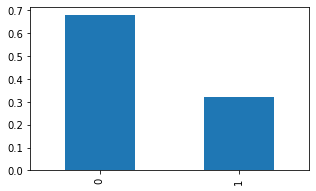

In [163]:
# Letus check our target columns & delay rate from our data.
rpd_df['target'].value_counts(normalize=True).plot.bar(figsize=(5,3))

**We can clearly see that more than 68% payments are getting delayed.**

In [164]:
# Creating drop column variable.
drop_cols=[]

In [165]:
#Since Time_btw_due & recpt_date is not usefull anymore , we can drop it.
drop_cols.append('Time_btw_due & recpt_date')

#### Checking other attributes one by one
<hr/>

<AxesSubplot:>

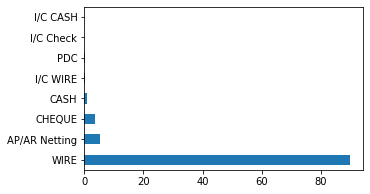

In [166]:
(rpd_df['RECEIPT_METHOD'].value_counts(normalize=True)*100).plot.barh(figsize=(5,3))

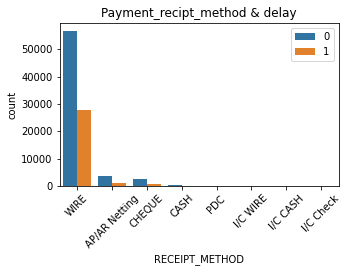

In [167]:
# Checking the receipt_method with our target column
plt.figure(figsize=(5,3))

sns.countplot(rpd_df['RECEIPT_METHOD'],hue=rpd_df['target'])
plt.xticks(rotation=45)
plt.title('Payment_recipt_method & delay')
plt.legend(loc=1)
plt.show()

We can clearly see that majority of payments are being received via WIRE, AP/AR Netting or Cheques.
Also we don't get enough information with respect to our target variable.

In [168]:
# Since we don't have problem with any of method of payment receipt . We can drop these column.
drop_cols.append("RECEIPT_METHOD")

In [169]:
# letus check RECEIPT_DOC_NO column
rpd_df['RECEIPT_DOC_NO'].nunique()

73

In [170]:
#check null Recipt_Doc_No.
rpd_df['RECEIPT_DOC_NO'].isnull().sum()

29

So we have 29 row items , which don't have Receipt_Doc_No , where as 73 unique doc_no.

In [171]:
#This is also just a reference no. of payment receipt , we can drop this column
drop_cols.append('RECEIPT_DOC_NO')

In [172]:
#Checking receipt date col.
rpd_df['RECEIPT_DATE'].isnull().sum()

0

There is no null values in receipt Date Column. Since we won't be having this column in test data set(Unseen Data) , we can drop this column too.


In [173]:
#adding to drop_cols list
drop_cols.append('RECEIPT_DATE')

In [174]:
# Checking Class column
rpd_df['CLASS'].value_counts(normalize=True)

PMT    1.0
Name: CLASS, dtype: float64

Since all the columns belongs to only one column , we can not use this column for model building . Hence adding it to drop_cols.

In [175]:
#adding to drop_cols list
drop_cols.append('CLASS')

<AxesSubplot:>

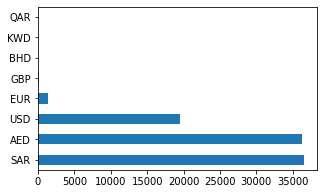

In [176]:
# Letus check CURRENCY_CODE column
plt.figure(figsize=(5,3))

rpd_df['CURRENCY_CODE'].value_counts().plot.barh()

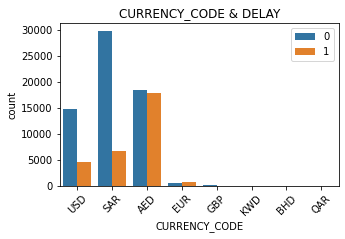

In [177]:
#Letus check currency_code with delays 
plt.figure(figsize=(5,3))

sns.countplot(rpd_df['CURRENCY_CODE'],hue=rpd_df['target'])
plt.xticks(rotation=45)
plt.title('CURRENCY_CODE & DELAY')
plt.legend(loc=1)
plt.show()

- **We can clearly see that Payment Currency AED have higher delays than other payment receipt currency.**
- **We can have some additional countermeasures for customers who pays in AED.**


In [178]:
#Letus check USD Amount column
rpd_df['USD Amount'].isnull().sum()

0

In [179]:
# Converting USD Amount in million USD.
rpd_df["USD Amount"]=np.round(rpd_df["USD Amount"]/1000000,2)

In [180]:
#Letus check USD Amount column
rpd_df['USD Amount'].quantile([0.1,0.25,0.5,0.75,0.9,1])

0.10     0.01
0.25     0.04
0.50     0.18
0.75     0.60
0.90     1.26
1.00    10.85
Name: USD Amount, dtype: float64

Seems like USD amount column have outliers.Letus explore further.

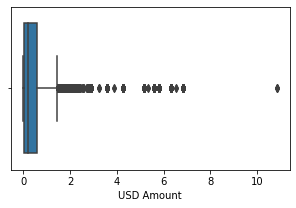

In [181]:
#boxplot to visualise outliers
plt.figure(figsize=(5,3))
sns.boxplot(rpd_df['USD Amount'],whis=1.5)
plt.show()

We could see that there is plenty of outliers . But these may be high value customers , so we cann't drop them.


Since  USD amount is already derivative of Local amount , we can choose only one column for model building. Since USD is global 
currency we can drop Local amount column.

In [182]:
# Adding Local_Amount to drop_cols
drop_cols.append("Local Amount")

In [183]:
# Checking INVOICE_ALLOCATED column
rpd_df['INVOICE_ALLOCATED'].value_counts()

1.0721E+11          4359
1.4821E+11          4000
1.5421E+11          3918
1.482E+11           3853
1.6021E+11          3418
                    ... 
IC15214821051078       1
IC15214821051177       1
IC15214820048949       1
IC15214821050520       1
IC15323921053765       1
Name: INVOICE_ALLOCATED, Length: 12986, dtype: int64

Since Invoice allocated is unique number given to a particular vendor.

In [184]:
# Checking PAYMENT_TERM column
rpd_df["PAYMENT_TERM"]


0             30 Days from EOM
1        30 Days from Inv Date
2        30 Days from Inv Date
3        30 Days from Inv Date
4        30 Days from Inv Date
                 ...          
93932                Immediate
93933                Immediate
93934                Immediate
93935    60 Days from Inv Date
93936         30 Days from EOM
Name: PAYMENT_TERM, Length: 93937, dtype: object

Since Payment term is in String format & not mentioned in any particular standard.

Therefore we need to derive numeric Payment_Term in days for our analysis.

In [185]:
# Deriving numeric Payment Term
rpd_df['Payment_Term_Days']=(rpd_df["DUE_DATE"]-rpd_df["INVOICE_CREATION_DATE"]).dt.days

In [186]:
# Checking the column
rpd_df['Payment_Term_Days'].min()

-3622

We should not get Payment_Term_Days in negative . Letus explore it & process it for correction.

In [187]:
temp=rpd_df[rpd_df['Payment_Term_Days']<0]
temp=temp[['PAYMENT_TERM','DUE_DATE','INVOICE_CREATION_DATE','Payment_Term_Days']]

temp.head()

,PAYMENT_TERM,DUE_DATE,INVOICE_CREATION_DATE,Payment_Term_Days
148,100% Adv Payment,2021-03-31,2021-04-01,-1
152,100% Adv Payment,2021-03-31,2021-04-01,-1
160,Immediate Payment,2021-03-01,2021-03-31,-30
161,Immediate,2021-03-01,2021-03-31,-30
167,100% Adv Payment,2021-03-31,2021-04-01,-1


In [188]:
temp.PAYMENT_TERM.value_counts()

Immediate Payment        2168
Immediate                 913
30 Days from Inv Date     366
100% Adv Payment           92
Cash on Delivery           87
30 Days from EOM           21
EOM                        16
On Consignment              9
7 Days from Inv Date        1
45 Days from Inv Date       1
Name: PAYMENT_TERM, dtype: int64

In [189]:
# Letus correct Payment_term_days in Original
def correction(x):
    if x in ("Immediate Payment","Immediate","100% Adv Payment","Cash on Delivery","On Consignment"):
        return  0
    elif x in ('30 Days from Inv Date','30 Days from EOM','EOM'):
        return  30
    elif x =='7 Days from Inv Date':
        return  1
    elif x =='45 Days from Inv Date':
        return  45
    else:
        pass

In [190]:
rpd_df['Payment_Term_Days']=rpd_df['PAYMENT_TERM'].apply(lambda x: correction(x))

In [191]:
rpd_df['Payment_Term_Days'].fillna((rpd_df["DUE_DATE"]-rpd_df["INVOICE_CREATION_DATE"]).dt.days,inplace=True)

In [192]:
rpd_df['Payment_Term_Days'].min()

0.0

Since Original Payment_Term column is no use for us now . We can drop the same.

In [193]:
# adding to drop_cols
drop_cols.append('PAYMENT_TERM')

<AxesSubplot:>

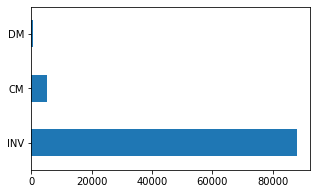

In [194]:
# Letus check Invoice_class column
plt.figure(figsize=(5,3))
rpd_df['INVOICE_CLASS'].value_counts().plot.barh()

We can clearly see that INV Class have highest invoices in our data set.

<AxesSubplot:>

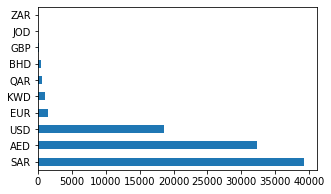

In [195]:
# letus check 'INVOICE_CURRENCY_CODE' column
plt.figure(figsize=(5,3))
rpd_df['INVOICE_CURRENCY_CODE'].value_counts().plot.barh()

As previously SAR, AED & USD are top currency codes in which invoice was parepared.

<AxesSubplot:>

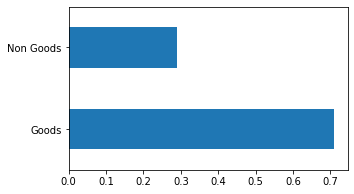

In [196]:
# letus check 'INVOICE_TYPE' column
plt.figure(figsize=(5,3))
rpd_df['INVOICE_TYPE'].value_counts(normalize=True).plot.barh()

We Can see that Goods & Non Goods ration is 70:30 for our data set.

### Bivariate Analysis --> Customers behaviour exploration based on past dataset.

In [197]:
EDA_df=rpd_df[['CUSTOMER_NAME','USD Amount','INVOICE_CLASS','INVOICE_CURRENCY_CODE',
               'INVOICE_TYPE','Time_btw_due & recpt_date',
              'target', 'Payment_Term_Days'
              ]]

In [198]:
# Checking Top 20 Customers based on USD_Amount
Grouped_USD = EDA_df.groupby(['CUSTOMER_NAME'])['USD Amount'].sum()

In [199]:
Grouped_USD=Grouped_USD.to_frame()

In [200]:
Grouped_USD = Grouped_USD.sort_values(by ='USD Amount',ascending=False)
Top_20 = Grouped_USD.head(20)

In [201]:
# Top_20 customers according to USD_values
Top_20

,USD Amount
CUSTOMER_NAME,
SEPH Corp,32524.52
FARO Corp,5790.68
PARF Corp,3197.77
ALLI Corp,2580.61
AREE Corp,1127.91
HABC Corp,533.50
RADW Corp,361.71
L OR Corp,295.31
CGR Corp,279.79


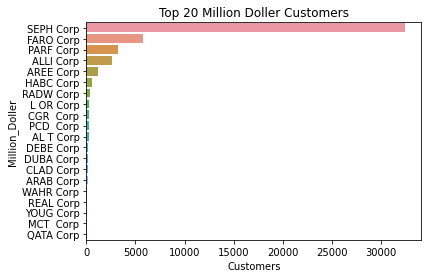

In [202]:
#Visualising them
colour = ['b','g','r','k','y','r','c']
sns.barplot(y=Top_20.index,x=Top_20['USD Amount'],orient='h')
plt.title("Top 20 Million Doller Customers")
plt.xlabel("Customers")
plt.ylabel("Million_Doller")
plt.show()

**We can see SEPH Corp,FARO Corp,PARF corp,ALLI Corp and AREE Corp are the top customers.**

In [203]:
# Checking Customers with our target variable_delayed
Grouped_target_delayed = EDA_df.groupby(['CUSTOMER_NAME'])['target'].sum() # Delayed payments by each customers
Grouped_target_delayed=Grouped_target_delayed.to_frame()
Grouped_target_delayed = Grouped_target_delayed.sort_values(by ='target',ascending=False)



In [204]:
# Checking Customers for total invoice counts
Grouped_target_total = EDA_df.groupby(['CUSTOMER_NAME'])['target'].count() # total payments by each customers
Grouped_target_total=Grouped_target_total.to_frame()
Grouped_target_total = Grouped_target_total.sort_values(by ='target',ascending=False)

In [205]:
# Merging both dataframes based on Customer_name
Merge_df=pd.merge(Grouped_target_delayed,Grouped_target_total,how='inner',on='CUSTOMER_NAME')

In [206]:
Merge_df.columns=["Delayed_Payment","Total_Payments"]

In [207]:
Merge_df['Delay%']=np.round(Merge_df['Delayed_Payment']/Merge_df['Total_Payments']*100,2)

In [208]:
# Checking Merge_df 
Merge_df.head()

,Delayed_Payment,Total_Payments,Delay%
CUSTOMER_NAME,,,
SEPH Corp,8056,23143,34.81
FARO Corp,3909,15004,26.05
ALLI Corp,3725,5645,65.99
RADW Corp,886,1647,53.79
PARF Corp,857,6624,12.94


In [209]:
# letus check Total_Payments average no.
Merge_df.Total_Payments.mean()

136.14057971014492

In [210]:
#Filtering out customers having greater than average Total Payments
Merge_df = Merge_df[Merge_df.Total_Payments>=Merge_df.Total_Payments.mean()].sort_values(by='Delay%',ascending=False)

In [211]:
Merge_df.head()

,Delayed_Payment,Total_Payments,Delay%
CUSTOMER_NAME,,,
CHAL Corp,190,214,88.79
TRAV Corp,135,155,87.10
3D D Corp,143,172,83.14
SAJ Corp,301,374,80.48
STYL Corp,393,496,79.23


In [212]:
# Getting Top_20 delay% Customers
Top_20_delayed=Merge_df[:20]

In [213]:
Top_20_delayed.head()

,Delayed_Payment,Total_Payments,Delay%
CUSTOMER_NAME,,,
CHAL Corp,190,214,88.79
TRAV Corp,135,155,87.10
3D D Corp,143,172,83.14
SAJ Corp,301,374,80.48
STYL Corp,393,496,79.23


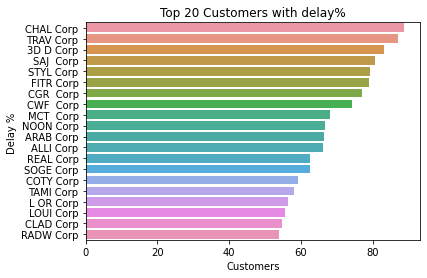

In [214]:
#Visualising them
colour = ['b','g','r','k','y','r','c']
sns.barplot(y=Top_20_delayed.index,x=Top_20_delayed['Delay%'],orient='h')
plt.title("Top 20 Customers with delay%")
plt.xlabel("Customers")
plt.ylabel("Delay % ")
plt.show()

**WE can see top 5 companies which are having higher delay  percentage are as below.**
 - CHAL Corp
 - TRAV Corp
 - 3D D Corp
 - SAJ Corp
 - STYL Corp

In [215]:
rpd_df.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'CUSTOMER_NUMBER', 'RECEIPT_DOC_NO',
       'RECEIPT_DATE', 'CLASS', 'CURRENCY_CODE', 'Local Amount', 'USD Amount',
       'INVOICE_ALLOCATED', 'INVOICE_CREATION_DATE', 'DUE_DATE',
       'PAYMENT_TERM', 'INVOICE_CLASS', 'INVOICE_CURRENCY_CODE',
       'INVOICE_TYPE', 'Actual_Days_for_Pmt', 'Time_btw_due & recpt_date',
       'target', 'Payment_Term_Days'],
      dtype='object')

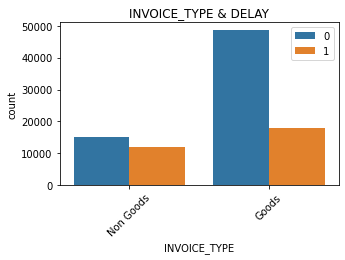

In [216]:
# Letus check the 'INVOICE_TYPE' & target column
plt.figure(figsize=(5,3))

sns.countplot(rpd_df['INVOICE_TYPE'],hue=rpd_df['target'])
plt.xticks(rotation=45)
plt.title('INVOICE_TYPE & DELAY')
plt.legend(loc=1)
plt.show()

**We can say that Non Goods category is having higher delays ration in comparison to Goods category.**

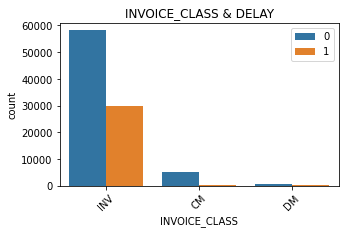

In [217]:
# Letus check the 'INVOICE_CLASS' & target column
plt.figure(figsize=(5,3))

sns.countplot(rpd_df['INVOICE_CLASS'],hue=rpd_df['target'])
plt.xticks(rotation=45)
plt.title('INVOICE_CLASS & DELAY')
plt.legend(loc=1)
plt.show()

**By looking it is very obivious that INV class invoices have only Delay.**

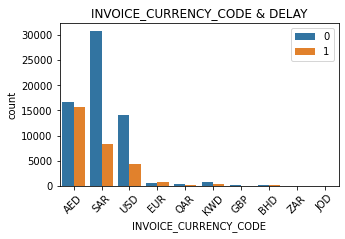

In [218]:
# Letus check the 'INVOICE_CURRENCY_CODE' & target column
plt.figure(figsize=(5,3))

sns.countplot(rpd_df['INVOICE_CURRENCY_CODE'],hue=rpd_df['target'])
plt.xticks(rotation=45)
plt.title('INVOICE_CURRENCY_CODE & DELAY')
plt.legend(loc=1)
plt.show()

- **We can clearly see that Payment Currency AED have higher delays than other payment receipt currency.**
- **We can have some additional countermeasures for customers who pays in AED.**

### Customer Segementation
<hr/>

**Recommendation Given:**
Customer-level attributes could also be important independent variables to be included in the model. A customer-level attribute can be determined via customer segmentation. You have to segment your customers based on two derived variables: the average payment time in days for a customer and the standard deviation for the payment time. Using clustering techniques would result in a few distinct clusters of customers, which can be used as an input variable for the ML model.



In [219]:
rpd_df.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'CUSTOMER_NUMBER', 'RECEIPT_DOC_NO',
       'RECEIPT_DATE', 'CLASS', 'CURRENCY_CODE', 'Local Amount', 'USD Amount',
       'INVOICE_ALLOCATED', 'INVOICE_CREATION_DATE', 'DUE_DATE',
       'PAYMENT_TERM', 'INVOICE_CLASS', 'INVOICE_CURRENCY_CODE',
       'INVOICE_TYPE', 'Actual_Days_for_Pmt', 'Time_btw_due & recpt_date',
       'target', 'Payment_Term_Days'],
      dtype='object')

In [220]:
# Calculating average days for payment on customer wise
Cust_segs1=rpd_df.groupby('CUSTOMER_NAME')['Actual_Days_for_Pmt'].mean()
Cust_segs1=Cust_segs1.to_frame()
Cust_segs1.reset_index
Cust_segs1.rename(columns = {'Actual_Days_for_Pmt':'Avg. days for Payment'}, inplace = True)
Cust_segs1.head()

,Avg. days for Payment
CUSTOMER_NAME,
3D D Corp,24.395349
6TH Corp,40.666667
A3 D Corp,45.400000
ABC Corp,16.000000
ABDU Corp,76.906250


In [221]:
# Calculating standard deviation for payment days on customer wise
Cust_segs2=rpd_df.groupby('CUSTOMER_NAME')['Actual_Days_for_Pmt'].std()
Cust_segs2=Cust_segs2.to_frame()
Cust_segs2.reset_index
Cust_segs2.rename(columns = {'Actual_Days_for_Pmt':'Std.deviation for Payment'}, inplace = True)
Cust_segs2.head()

,Std.deviation for Payment
CUSTOMER_NAME,
3D D Corp,13.040449
6TH Corp,7.952987
A3 D Corp,52.581366
ABC Corp,0.000000
ABDU Corp,54.919326


In [222]:
# Merging both dataframes
Cust_seg=pd.merge(Cust_segs1,Cust_segs2,how='inner',on='CUSTOMER_NAME')

In [223]:
Cust_seg.head()

,Avg. days for Payment,Std.deviation for Payment
CUSTOMER_NAME,,
3D D Corp,24.395349,13.040449
6TH Corp,40.666667,7.952987
A3 D Corp,45.400000,52.581366
ABC Corp,16.000000,0.000000
ABDU Corp,76.906250,54.919326


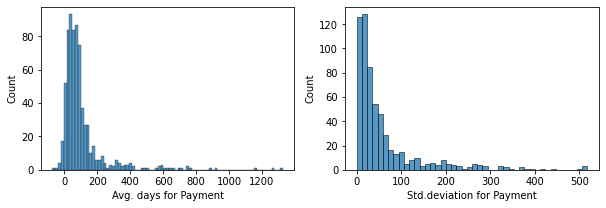

In [224]:
#Letus check Avg.days for Payments
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.histplot(Cust_seg['Avg. days for Payment'])


plt.subplot(1,2,2)
sns.histplot(Cust_seg['Std.deviation for Payment'])
plt.show()

**WE can see that both attributes are not normalised. Hence we need to do Scaling.**


In [225]:
#importing library
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
Cust_seg[['Avg. days for Payment','Std.deviation for Payment']]=scaler.fit_transform(Cust_seg[['Avg. days for Payment','Std.deviation for Payment']])

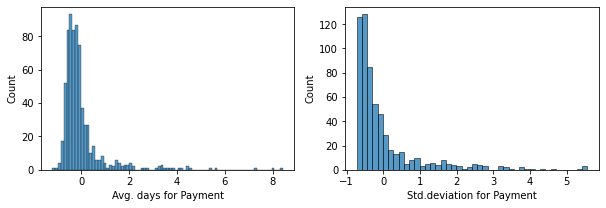

In [226]:
# Letus check again
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.histplot(Cust_seg['Avg. days for Payment'])

plt.subplot(1,2,2)
sns.histplot(Cust_seg['Std.deviation for Payment'])
plt.show()

In [227]:
Cust_seg.reset_index(inplace=True)
Cust_seg['Std.deviation for Payment'].fillna(0,inplace=True)

In [228]:
Clust_df=Cust_seg.copy()
Clust_df.head()

,CUSTOMER_NAME,Avg. days for Payment,Std.deviation for Payment
0,3D D Corp,-0.539379,-0.569399
1,6TH Corp,-0.427407,-0.631189
2,A3 D Corp,-0.394835,-0.089152
3,ABC Corp,-0.597152,-0.727783
4,ABDU Corp,-0.178023,-0.060756


In [229]:
#dropping customer_name for clustering
Clust_df.drop('CUSTOMER_NAME',axis=1,inplace=True)
Clust_df.head()

,Avg. days for Payment,Std.deviation for Payment
0,-0.539379,-0.569399
1,-0.427407,-0.631189
2,-0.394835,-0.089152
3,-0.597152,-0.727783
4,-0.178023,-0.060756


In [230]:
#importing library
import sklearn

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [231]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(Clust_df)
kmeans.cluster_centers_

array([[-0.31017355, -0.33096979],
       [ 0.50335711,  0.96031833],
       [ 1.77276116,  3.46461734],
       [ 4.5685419 ,  0.49333719]])

#### Finding the Optimal Number of Clusters

In [232]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(Clust_df)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(Clust_df, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.751220065255244
For n_clusters=3, the silhouette score is 0.7319917261760829
For n_clusters=4, the silhouette score is 0.6188501658848016
For n_clusters=5, the silhouette score is 0.6061276827754781
For n_clusters=6, the silhouette score is 0.3980576688067705
For n_clusters=7, the silhouette score is 0.40137925811299136
For n_clusters=8, the silhouette score is 0.41913977001591984


**We could see n_clusters are decent according to Silhouette Score.**

In [233]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(Clust_df)

KMeans(max_iter=50, n_clusters=3)

In [234]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [235]:
# assign the label
Cust_seg['cluster_id'] = kmeans.labels_
Cust_seg.head()

,CUSTOMER_NAME,Avg. days for Payment,Std.deviation for Payment,cluster_id
0,3D D Corp,-0.539379,-0.569399,0
1,6TH Corp,-0.427407,-0.631189,0
2,A3 D Corp,-0.394835,-0.089152,0
3,ABC Corp,-0.597152,-0.727783,0
4,ABDU Corp,-0.178023,-0.060756,0


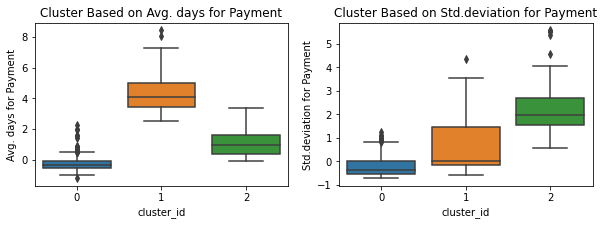

In [236]:
# plotting 
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.boxplot(x='cluster_id', y='Avg. days for Payment', data=Cust_seg)
plt.title("Cluster Based on Avg. days for Payment")


plt.subplot(1,2,2)
sns.boxplot(x='cluster_id', y='Std.deviation for Payment', data=Cust_seg)
plt.title("Cluster Based on Std.deviation for Payment")
plt.show()


**Based on Avg.days for Payment clusters ,we can see three clusters as below-**

   '0' Cluster -- Fast Invoice Payment
   
   '1' Cluster -- Delay/Late Invoice Payment
   
   '2' Cluster -- Medium Invoice Payment



### Data Preparation for Model Building
<hr/>

In [237]:
rpd_df.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'CUSTOMER_NUMBER', 'RECEIPT_DOC_NO',
       'RECEIPT_DATE', 'CLASS', 'CURRENCY_CODE', 'Local Amount', 'USD Amount',
       'INVOICE_ALLOCATED', 'INVOICE_CREATION_DATE', 'DUE_DATE',
       'PAYMENT_TERM', 'INVOICE_CLASS', 'INVOICE_CURRENCY_CODE',
       'INVOICE_TYPE', 'Actual_Days_for_Pmt', 'Time_btw_due & recpt_date',
       'target', 'Payment_Term_Days'],
      dtype='object')

In [238]:
drop_cols.append('CUSTOMER_NUMBER')# Dropping columns -unique identification
drop_cols.append('CURRENCY_CODE')# Checking only invoice level columns
drop_cols.append('INVOICE_CREATION_DATE')# Derived columns used instead of it
drop_cols.append('DUE_DATE')# Derived columns used instead of it
drop_cols.append('Actual_Days_for_Pmt')# Derived columns used instead of it

In [239]:
rpd_df_m=rpd_df.drop(drop_cols,axis=1)

In [240]:
rpd_df_m.head()

,CUSTOMER_NAME,USD Amount,INVOICE_ALLOCATED,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,target,Payment_Term_Days
0,C EA Corp,0.10,14200000001,INV,AED,Non Goods,0,30.0
1,RADW Corp,0.05,99200000043,INV,SAR,Non Goods,0,30.0
2,RADW Corp,0.04,99210000003,INV,SAR,Non Goods,1,30.0
3,FARO Corp,0.04,99200000038,INV,SAR,Non Goods,0,30.0
4,RADW Corp,0.04,99200000039,INV,SAR,Non Goods,0,30.0


In [241]:
rpd_df_m=pd.merge(rpd_df_m,Cust_seg,how='left',on='CUSTOMER_NAME')

In [242]:
rpd_df_m.drop(['Avg. days for Payment','Std.deviation for Payment','CUSTOMER_NAME','INVOICE_ALLOCATED'],axis=1,inplace=True)

In [243]:
rpd_df_m.head()

,USD Amount,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,target,Payment_Term_Days,cluster_id
0,0.10,INV,AED,Non Goods,0,30.0,0
1,0.05,INV,SAR,Non Goods,0,30.0,0
2,0.04,INV,SAR,Non Goods,1,30.0,0
3,0.04,INV,SAR,Non Goods,0,30.0,2
4,0.04,INV,SAR,Non Goods,0,30.0,0


In [244]:
Cat_cols=['INVOICE_CLASS','INVOICE_CURRENCY_CODE','INVOICE_TYPE']

In [245]:
#dummy variable creation
dummies=pd.get_dummies(rpd_df[Cat_cols],drop_first=True)

In [246]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   INVOICE_CLASS_DM           93937 non-null  uint8
 1   INVOICE_CLASS_INV          93937 non-null  uint8
 2   INVOICE_CURRENCY_CODE_BHD  93937 non-null  uint8
 3   INVOICE_CURRENCY_CODE_EUR  93937 non-null  uint8
 4   INVOICE_CURRENCY_CODE_GBP  93937 non-null  uint8
 5   INVOICE_CURRENCY_CODE_JOD  93937 non-null  uint8
 6   INVOICE_CURRENCY_CODE_KWD  93937 non-null  uint8
 7   INVOICE_CURRENCY_CODE_QAR  93937 non-null  uint8
 8   INVOICE_CURRENCY_CODE_SAR  93937 non-null  uint8
 9   INVOICE_CURRENCY_CODE_USD  93937 non-null  uint8
 10  INVOICE_CURRENCY_CODE_ZAR  93937 non-null  uint8
 11  INVOICE_TYPE_Non Goods     93937 non-null  uint8
dtypes: uint8(12)
memory usage: 1.1 MB


In [247]:
# merging dataframe
rpd_df_m=pd.concat([rpd_df_m,dummies],axis=1)

In [248]:
rpd_df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93937 entries, 0 to 93936
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   USD Amount                 93937 non-null  float64
 1   INVOICE_CLASS              93937 non-null  object 
 2   INVOICE_CURRENCY_CODE      93937 non-null  object 
 3   INVOICE_TYPE               93937 non-null  object 
 4   target                     93937 non-null  int64  
 5   Payment_Term_Days          93937 non-null  float64
 6   cluster_id                 93937 non-null  int32  
 7   INVOICE_CLASS_DM           93937 non-null  uint8  
 8   INVOICE_CLASS_INV          93937 non-null  uint8  
 9   INVOICE_CURRENCY_CODE_BHD  93937 non-null  uint8  
 10  INVOICE_CURRENCY_CODE_EUR  93937 non-null  uint8  
 11  INVOICE_CURRENCY_CODE_GBP  93937 non-null  uint8  
 12  INVOICE_CURRENCY_CODE_JOD  93937 non-null  uint8  
 13  INVOICE_CURRENCY_CODE_KWD  93937 non-null  uin

In [249]:
# dropping original columns
rpd_df_m.drop(Cat_cols,axis=1,inplace=True)

In [250]:
rpd_df_m.shape

(93937, 16)

In [251]:
# Checking the percentage of missing values
round(100*(rpd_df_m.isnull().sum()/len(rpd_df_m.index)), 2)

USD Amount                   0.0
target                       0.0
Payment_Term_Days            0.0
cluster_id                   0.0
INVOICE_CLASS_DM             0.0
INVOICE_CLASS_INV            0.0
INVOICE_CURRENCY_CODE_BHD    0.0
INVOICE_CURRENCY_CODE_EUR    0.0
INVOICE_CURRENCY_CODE_GBP    0.0
INVOICE_CURRENCY_CODE_JOD    0.0
INVOICE_CURRENCY_CODE_KWD    0.0
INVOICE_CURRENCY_CODE_QAR    0.0
INVOICE_CURRENCY_CODE_SAR    0.0
INVOICE_CURRENCY_CODE_USD    0.0
INVOICE_CURRENCY_CODE_ZAR    0.0
INVOICE_TYPE_Non Goods       0.0
dtype: float64

In [252]:
rpd_df_m.dropna(inplace=True)

In [253]:
rpd_df_m.columns

Index(['USD Amount', 'target', 'Payment_Term_Days', 'cluster_id',
       'INVOICE_CLASS_DM', 'INVOICE_CLASS_INV', 'INVOICE_CURRENCY_CODE_BHD',
       'INVOICE_CURRENCY_CODE_EUR', 'INVOICE_CURRENCY_CODE_GBP',
       'INVOICE_CURRENCY_CODE_JOD', 'INVOICE_CURRENCY_CODE_KWD',
       'INVOICE_CURRENCY_CODE_QAR', 'INVOICE_CURRENCY_CODE_SAR',
       'INVOICE_CURRENCY_CODE_USD', 'INVOICE_CURRENCY_CODE_ZAR',
       'INVOICE_TYPE_Non Goods'],
      dtype='object')

There is no null values in our dataframe.

In [254]:
rpd_df_m.Payment_Term_Days.describe()          

count    93937.000000
mean        44.483207
std         27.502154
min          0.000000
25%         30.000000
50%         43.000000
75%         60.000000
max        365.000000
Name: Payment_Term_Days, dtype: float64

#### Spliting Data in train & Test set


In [255]:
#importing libraries
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [256]:
# Putting feature variable to y
y = rpd_df_m.pop('target')
X=rpd_df_m

In [257]:
X.head()

,USD Amount,Payment_Term_Days,cluster_id,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,INVOICE_TYPE_Non Goods
0,0.10,30.0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0.05,30.0,0,0,1,0,0,0,0,0,0,1,0,0,1
2,0.04,30.0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,0.04,30.0,2,0,1,0,0,0,0,0,0,1,0,0,1
4,0.04,30.0,0,0,1,0,0,0,0,0,0,1,0,0,1


In [258]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: target, dtype: int64

In [259]:
print(X.shape)
print(y.shape)

(93937, 15)
(93937,)


In [260]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

#### Feature Scaling

In [261]:
from sklearn.preprocessing import MinMaxScaler

In [262]:
scaler = MinMaxScaler()

X_train[['Payment_Term_Days']] = scaler.fit_transform(X_train[['Payment_Term_Days']])

X_train.head()

,USD Amount,Payment_Term_Days,cluster_id,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,INVOICE_TYPE_Non Goods
214,0.07,0.082192,2,0,1,0,0,0,0,0,0,0,1,0,1
28353,0.59,0.082192,0,0,1,0,0,0,0,0,0,0,1,0,0
70381,0.10,0.082192,0,0,1,0,0,0,0,0,0,0,0,0,1
93001,0.00,0.082192,0,0,1,0,0,0,0,0,0,0,0,0,0
91650,0.60,0.082192,0,0,1,0,0,0,0,0,0,0,0,0,0


#### Looking at Correlations


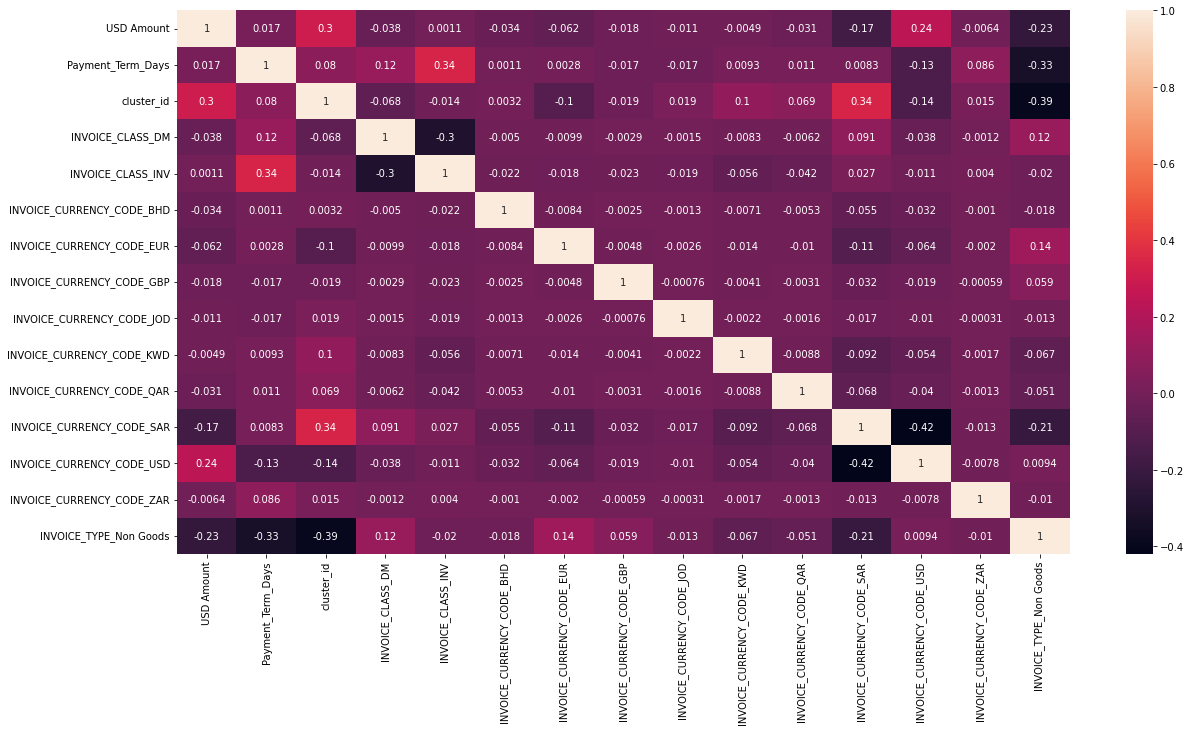

In [263]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(rpd_df_m.corr(),annot = True)
plt.show()

**We don't find any high correlation between variables.**

### Model Building
<hr/>

### 1st Model

In [317]:
# Logistic regression model
X_train_sm = sm.add_constant(X_train)
logm1 = sm.GLM(y_train,(X_train_sm), family = sm.families.Binomial())
res=logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                65755
Model:                            GLM   Df Residuals:                    65739
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34411.
Date:                Tue, 14 Mar 2023   Deviance:                       68821.
Time:                        04:45:50   Pearson chi2:                 6.53e+04
No. Iterations:                    22   Pseudo R-squ. (CS):             0.1888
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -4.6019      0.138    -33.368      0.000      -4.872      -4.332
USD Amount                    0.2541      0.011     22.836      0.000       0.232       0.276
Payment_Term_Days            10.9580      0.167     65.721      0.000      10.631      11.285
cluster_id                   -0.0012      0.011     -0.105      0.916      -0.023       0.021
INVOICE_CLASS_DM             -0.9425      0.220     -4.282      0.000      -1.374      -0.511
INVOICE_CLASS_INV             2.3472      0.138     17.040      0.000       2.077       2.617
INVOICE_CURRENCY_CODE_BHD     0.1647      0.138      1.191      0.234      -0.106       0.436
INVOICE_CURRENCY_CODE_EUR     0.2746      0.077      3.573      0.000       0.124       0.425
INVOICE_CURRENCY_CODE_GBP    -2.0484      0.292     -7.015      0.000      -2.621      -1.476
INVOICE_CURRENCY_CODE_JOD   -21.7921   1.46e+04     -0.001      0.999   -2.87e+04    2.87e+04
INVOICE_CURRENCY_CODE_KWD    -0.3020      0.088     -3.418      0.001      -0.475      -0.129
INVOICE_CURRENCY_CODE_QAR    -0.8317      0.132     -6.305      0.000      -1.090      -0.573
INVOICE_CURRENCY_CODE_SAR    -0.8113      0.023    -35.307      0.000      -0.856      -0.766
INVOICE_CURRENCY_CODE_USD    -0.9365      0.027    -34.234      0.000      -0.990      -0.883
INVOICE_CURRENCY_CODE_ZAR   -27.1994   2.12e+04     -0.001      0.999   -4.17e+04    4.16e+04
INVOICE_TYPE_Non Goods        1.5416      0.027     57.245      0.000       1.489       1.594
=============================================================================================
"""

In [265]:
# dropping high p-value columns
cols=X_train.columns
cols=cols.drop(['cluster_id','INVOICE_CURRENCY_CODE_BHD','INVOICE_CURRENCY_CODE_JOD','INVOICE_CURRENCY_CODE_ZAR'])

### 2nd Model

In [266]:
# Building second model
# Logistic regression model
X_train_sm=sm.add_constant(X_train[cols])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res=logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                65755
Model:                            GLM   Df Residuals:                    65743
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34467.
Date:                Tue, 14 Mar 2023   Deviance:                       68934.
Time:                        04:44:07   Pearson chi2:                 6.57e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1874
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -4.5977      0.137    -33.455      0.000      -4.867      -4.328
USD Amount                    0.2535      0.010     24.188      0.000       0.233       0.274
Payment_Term_Days            10.8321      0.166     65.239      0.000      10.507      11.158
INVOICE_CLASS_DM             -0.9075      0.220     -4.128      0.000      -1.338      -0.477
INVOICE_CLASS_INV             2.3619      0.138     17.151      0.000       2.092       2.632
INVOICE_CURRENCY_CODE_EUR     0.2770      0.077      3.612      0.000       0.127       0.427
INVOICE_CURRENCY_CODE_GBP    -2.0417      0.292     -6.997      0.000      -2.614      -1.470
INVOICE_CURRENCY_CODE_KWD    -0.3019      0.088     -3.449      0.001      -0.473      -0.130
INVOICE_CURRENCY_CODE_QAR    -0.8322      0.131     -6.337      0.000      -1.090      -0.575
INVOICE_CURRENCY_CODE_SAR    -0.8122      0.022    -37.176      0.000      -0.855      -0.769
INVOICE_CURRENCY_CODE_USD    -0.9362      0.027    -34.328      0.000      -0.990      -0.883
INVOICE_TYPE_Non Goods        1.5333      0.026     58.568      0.000       1.482       1.585
=============================================================================================
"""

In [267]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [268]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,INVOICE_CLASS_INV,10.54
1,Payment_Term_Days,5.39
8,INVOICE_CURRENCY_CODE_SAR,2.26
10,INVOICE_TYPE_Non Goods,1.93
9,INVOICE_CURRENCY_CODE_USD,1.60
0,USD Amount,1.47
2,INVOICE_CLASS_DM,1.26
4,INVOICE_CURRENCY_CODE_EUR,1.06
6,INVOICE_CURRENCY_CODE_KWD,1.03
7,INVOICE_CURRENCY_CODE_QAR,1.02


Since 'INVOICE_CLASS_INV' have high VIF value , letus drop this column

In [269]:
#dropping INVOICE_CLASS_INV column
cols=cols.drop('INVOICE_CLASS_INV')

### 3rd Model

In [270]:
# Logistic regression model
X_train_sm=sm.add_constant(X_train[cols])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res=logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                65755
Model:                            GLM   Df Residuals:                    65744
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34770.
Date:                Tue, 14 Mar 2023   Deviance:                       69541.
Time:                        04:44:25   Pearson chi2:                 6.65e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1798
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -2.4811      0.034    -72.860      0.000      -2.548      -2.414
USD Amount                    0.2574      0.011     24.479      0.000       0.237       0.278
Payment_Term_Days            12.0287      0.159     75.655      0.000      11.717      12.340
INVOICE_CLASS_DM             -3.4353      0.169    -20.381      0.000      -3.766      -3.105
INVOICE_CURRENCY_CODE_EUR     0.1758      0.074      2.373      0.018       0.031       0.321
INVOICE_CURRENCY_CODE_GBP    -2.1228      0.289     -7.345      0.000      -2.689      -1.556
INVOICE_CURRENCY_CODE_KWD    -0.3222      0.086     -3.738      0.000      -0.491      -0.153
INVOICE_CURRENCY_CODE_QAR    -0.8284      0.130     -6.361      0.000      -1.084      -0.573
INVOICE_CURRENCY_CODE_SAR    -0.7696      0.022    -35.441      0.000      -0.812      -0.727
INVOICE_CURRENCY_CODE_USD    -0.9067      0.027    -33.238      0.000      -0.960      -0.853
INVOICE_TYPE_Non Goods        1.6150      0.026     62.478      0.000       1.564       1.666
=============================================================================================
"""

In [271]:
# Checking VIF again.
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,Payment_Term_Days,1.95
7,INVOICE_CURRENCY_CODE_SAR,1.56
0,USD Amount,1.37
8,INVOICE_CURRENCY_CODE_USD,1.37
9,INVOICE_TYPE_Non Goods,1.22
3,INVOICE_CURRENCY_CODE_EUR,1.05
2,INVOICE_CLASS_DM,1.04
5,INVOICE_CURRENCY_CODE_KWD,1.02
4,INVOICE_CURRENCY_CODE_GBP,1.01
6,INVOICE_CURRENCY_CODE_QAR,1.01


 All variables VIF is in acceptable range . Hence we can proceed with this model.

In [272]:
### Checking for accuracy & other metrics of model
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [273]:
y_train_pred[:10]

array([0.31733222, 0.09558852, 0.53701192, 0.18355257, 0.20783878,
       0.06103978, 0.34365494, 0.12023474, 0.52129308, 0.37746726])

In [274]:
y_train_pred_final = pd.DataFrame({'Delay':y_train.values, 'Delay_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Delay,Delay_Prob,CustID
0,0,0.317332,214
1,0,0.095589,28353
2,1,0.537012,70381
3,0,0.183553,93001
4,0,0.207839,91650


In [275]:
# Creating new column 'predicted' with 1 if Delay_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Delay_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Delay,Delay_Prob,CustID,predicted
0,0,0.317332,214,0
1,0,0.095589,28353,0
2,1,0.537012,70381,1
3,0,0.183553,93001,0
4,0,0.207839,91650,0


In [276]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix

In [277]:
# Let's check the overall accuracy.
print(accuracy_score(y_train_pred_final.Delay, y_train_pred_final.predicted))

0.735959242643145


We have 73.6% accuracy on our train data set.

In [278]:
#Letus check confusion matrix
confusion = confusion_matrix(y_train_pred_final.Delay, y_train_pred_final.predicted )
confusion

array([[37805,  6817],
       [10545, 10588]])

In [279]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [280]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.5010173662045143

In [281]:
# Let us calculate specificity
TN / float(TN+FP)

0.8472278248397651

### Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [282]:
from sklearn.metrics import recall_score,precision_score,roc_auc_score,roc_curve

In [283]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [284]:
fpr, tpr, thresholds = roc_curve(y_train_pred_final.Delay,y_train_pred_final.Delay_Prob,drop_intermediate = False)

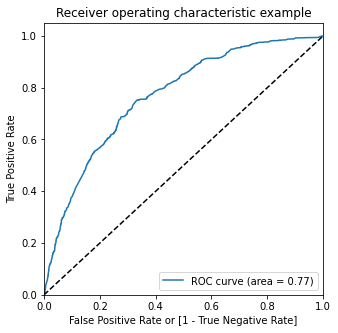

In [285]:
draw_roc(y_train_pred_final.Delay,y_train_pred_final.Delay_Prob)

### Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificitym

In [286]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Delay_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Delay,Delay_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.317332,214,0,1,1,1,1,0,0,0,0,0,0
1,0,0.095589,28353,0,1,0,0,0,0,0,0,0,0,0
2,1,0.537012,70381,1,1,1,1,1,1,1,0,0,0,0
3,0,0.183553,93001,0,1,1,0,0,0,0,0,0,0,0
4,0,0.207839,91650,0,1,1,1,0,0,0,0,0,0,0


In [287]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Delay, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.321390  1.000000  0.000000
0.1   0.1  0.478975  0.971088  0.245910
0.2   0.2  0.596152  0.883642  0.459997
0.3   0.3  0.687796  0.754980  0.655977
0.4   0.4  0.720386  0.593763  0.780355
0.5   0.5  0.735959  0.501017  0.847228
0.6   0.6  0.714257  0.198457  0.958541
0.7   0.7  0.695536  0.084938  0.984716
0.8   0.8  0.682899  0.022619  0.995608
0.9   0.9  0.679796  0.008707  0.997624


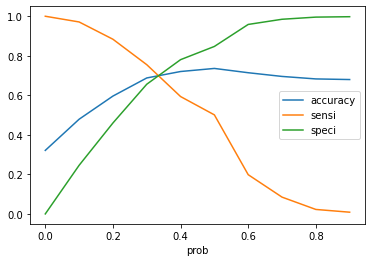

In [288]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [289]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Delay_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Delay,Delay_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.317332,214,0,1,1,1,1,0,0,0,0,0,0,1
1,0,0.095589,28353,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.537012,70381,1,1,1,1,1,1,1,0,0,0,0,1
3,0,0.183553,93001,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.207839,91650,0,1,1,1,0,0,0,0,0,0,0,0


In [290]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Delay, y_train_pred_final.final_predicted)

0.687795604896966

In [291]:
# Precision Score
precision_score(y_train_pred_final.Delay, y_train_pred_final.final_predicted)

0.5096467130901424

In [292]:
# Recall Score
recall_score(y_train_pred_final.Delay, y_train_pred_final.final_predicted)

0.754980362466285

In [293]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_train_pred_final.Delay, y_train_pred_final.Delay_Prob)

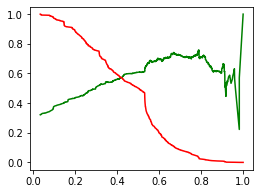

In [294]:
plt.figure(figsize=(4,3))
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

#### On Precision & Recall trade off we found optimal cutoff of between 0.4 & 0.5 . Hence Changing optimal cutoff from 0.3 to 0.43

In [295]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Delay_Prob.map( lambda x: 1 if x > 0.43 else 0)

y_train_pred_final.head()

,Delay,Delay_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.317332,214,0,1,1,1,1,0,0,0,0,0,0,0
1,0,0.095589,28353,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.537012,70381,1,1,1,1,1,1,1,0,0,0,0,1
3,0,0.183553,93001,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.207839,91650,0,1,1,1,0,0,0,0,0,0,0,0


In [296]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Delay, y_train_pred_final.final_predicted)

0.7309406128811498

### Making predictions on the test set

In [297]:
X_test[['Payment_Term_Days']] = scaler.transform(X_test[['Payment_Term_Days']])

X_test.head()

,USD Amount,Payment_Term_Days,cluster_id,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,INVOICE_TYPE_Non Goods
84001,0.02,0.082192,0,0,1,0,0,0,0,0,0,0,0,0,1
24346,5.16,0.169863,2,0,1,0,0,0,0,0,0,0,0,0,0
53029,0.02,0.082192,0,0,1,0,0,0,0,0,0,0,0,0,1
73501,0.22,0.082192,2,0,1,0,0,0,0,0,0,0,1,0,1
46575,0.79,0.082192,2,0,1,0,0,0,0,0,0,1,0,0,1


In [298]:
X_test = X_test[cols]
X_test.head()

,USD Amount,Payment_Term_Days,INVOICE_CLASS_DM,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_TYPE_Non Goods
84001,0.02,0.082192,0,0,0,0,0,0,0,1
24346,5.16,0.169863,0,0,0,0,0,0,0,0
53029,0.02,0.082192,0,0,0,0,0,0,0,1
73501,0.22,0.082192,0,0,0,0,0,0,1,1
46575,0.79,0.082192,0,0,0,0,0,1,0,1


In [299]:
X_test_sm = sm.add_constant(X_test)

In [300]:
#Making predictions on the test set

y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

84001    0.531888
24346    0.708985
53029    0.531888
73501    0.325756
46575    0.390865
41952    0.278556
2843     0.320986
71566    0.535732
56661    0.628318
47901    0.347147
dtype: float64

In [301]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [302]:
# Let's see the head
y_pred_1.head()

,0
84001,0.531888
24346,0.708985
53029,0.531888
73501,0.325756
46575,0.390865


In [303]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [304]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [305]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [306]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [307]:
y_pred_final.head()

,target,CustID,0
0,1,84001,0.531888
1,1,24346,0.708985
2,1,53029,0.531888
3,1,73501,0.325756
4,1,46575,0.390865


In [308]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Delay_Prob','target':'Delay'})

In [309]:
# Let's see the head of y_pred_final
y_pred_final.head()

,Delay,CustID,Delay_Prob
0,1,84001,0.531888
1,1,24346,0.708985
2,1,53029,0.531888
3,1,73501,0.325756
4,1,46575,0.390865


In [310]:
y_pred_final['final_predicted'] = y_pred_final.Delay_Prob.map(lambda x: 1 if x > 0.43 else 0)

In [311]:
y_pred_final.head()

,Delay,CustID,Delay_Prob,final_predicted
0,1,84001,0.531888,1
1,1,24346,0.708985,1
2,1,53029,0.531888,1
3,1,73501,0.325756,0
4,1,46575,0.390865,0


In [312]:
# Let's check the overall accuracy.
accuracy_score(y_pred_final.Delay, y_pred_final.final_predicted)

0.7339081683343979

In [313]:
confusion2 = confusion_matrix(y_pred_final.Delay, y_pred_final.final_predicted )
confusion2

array([[15610,  3622],
       [ 3877,  5073]])

In [314]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [315]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.5668156424581006

In [316]:
# Let us calculate specificity
TN / float(TN+FP)

0.8116680532445923

## Summary of our model-3
<hr/>

- Train Accuracy- 73.6%   
- Test Accuracy -73.39%

In [352]:
# Reading Open.CSV file
open_df=pd.read_csv('Open_Invoice_data.csv',encoding= 'unicode_escape')
open_df.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [353]:
open_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88204 entries, 0 to 88203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AS_OF_DATE            88204 non-null  object 
 1   Customer Type         88204 non-null  object 
 2   Customer_Name         88204 non-null  object 
 3   Customer Account No   88201 non-null  float64
 4   Transaction Number    88195 non-null  object 
 5   Transaction Date      88204 non-null  object 
 6   Payment Term          88204 non-null  object 
 7   Due Date              88204 non-null  object 
 8   Transaction Currency  88204 non-null  object 
 9   Local Amount          88204 non-null  object 
 10  Transaction Class     88204 non-null  object 
 11  AGE                   88204 non-null  int64  
 12  USD Amount            88204 non-null  object 
 13  INV_CREATION_DATE     88204 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 9.4+ MB


### EDA & Data Preparation

In [354]:
open_df.AS_OF_DATE.value_counts()

04-APR-2022 01:07:01    88204
Name: AS_OF_DATE, dtype: int64

In [355]:
#dropping the col
drop_column=[]
drop_column.append('AS_OF_DATE')

In [356]:

open_df['Customer Type'].value_counts()

3rd Party                45282
Related Party            42919
Unidentified Receipts        3
Name: Customer Type, dtype: int64

Since Column is not required for prediction , hence dropping this column also.

In [357]:
#dropping the col
drop_column=['AS_OF_DATE','Customer Type','Customer Account No','Transaction Number','Transaction Date','Local Amount']

In [358]:
# dropping irrelevant columns
open_df=open_df.drop(drop_column,axis=1)

In [359]:
open_df.head()

,Customer_Name,Payment Term,Due Date,Transaction Currency,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,GIVE Corp,Immediate,21/12/2021,AED,CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,AL J Corp,30 Days from Inv Date,03/03/2022,USD,INVOICE,33,"2,000",2/1/2022 14:09
2,AL J Corp,30 Days from Inv Date,23/04/2022,USD,INVOICE,-18,"2,000",3/24/2022 17:46
3,AL R Corp,15 Days from Inv Date,19/01/2022,AED,INVOICE,76,"2,415",1/5/2022 11:49
4,ALLI Corp,30 Days from EOM,30/04/2022,AED,INVOICE,-25,"3,800",3/3/2022 22:30


In [360]:
#Letus match the name of columns as our received payment data
open_df.rename(columns={'Customer_Name':'CUSTOMER_NAME',"Transaction Currency": 'INVOICE_CURRENCY_CODE',"Transaction Class":'INVOICE_CLASS'},inplace=True)

In [361]:
# Adding customer segment column in Open_df
open_df=pd.merge(open_df,Cust_seg,how='left',on='CUSTOMER_NAME')

In [362]:
open_df.cluster_id.value_counts()

0.0    51223
2.0    34471
1.0       43
Name: cluster_id, dtype: int64

In [363]:
open_df['USD Amount'].dtype

dtype('O')

In [364]:
#Changing it to numbers
open_df['USD Amount'] = [float(str(i).replace(",", "")) for i in open_df['USD Amount']]


In [365]:
open_df['USD Amount'].max()

5978000.0

In [366]:

# Converting USD Amount in million
open_df['USD Amount']=open_df['USD Amount']/1000000

In [367]:
open_df.columns

Index(['CUSTOMER_NAME', 'Payment Term', 'Due Date', 'INVOICE_CURRENCY_CODE',
       'INVOICE_CLASS', 'AGE', 'USD Amount', 'INV_CREATION_DATE',
       'Avg. days for Payment', 'Std.deviation for Payment', 'cluster_id'],
      dtype='object')

In [368]:


# checking 'INVOICE_CLASS' column
open_df['INVOICE_CLASS'].value_counts()

INVOICE        79523
CREDIT NOTE     5954
PAYMENT         1443
DEBIT NOTE      1284
Name: INVOICE_CLASS, dtype: int64

In [369]:
# Chaning Inoice- INV
         #Credit Note- CM
         #Debit Note -DM
         #Payment -PMT
def change(x):
    if x=='INVOICE':
        return 'INV'
    elif x=='CREDIT NOTE':
        return 'CM'
    elif x=='DEBIT NOTE':
        return 'DM'
    elif x=='PAYMENT':
        return 'PMT'
    else:
        Pass


In [370]:
open_df['INVOICE_CLASS']=open_df['INVOICE_CLASS'].apply(lambda x: change(x))

In [371]:
open_df['INVOICE_CLASS'].value_counts()

INV    79523
CM      5954
PMT     1443
DM      1284
Name: INVOICE_CLASS, dtype: int64

In [372]:
open_df['INV_CREATION_DATE'].dtype

dtype('O')

In [373]:
# Changing it to date.
open_df['INV_CREATION_DATE']=[(str(i).replace("-", "/")) for i in open_df['INV_CREATION_DATE']]

In [374]:
from datetime import datetime
open_df['INV_CREATION_DATE']=open_df['INV_CREATION_DATE'].apply(lambda val: datetime.strptime(val, "%m/%d/%Y %H:%M" ))

In [375]:
open_df['INV_CREATION_DATE']=open_df['INV_CREATION_DATE'].dt.strftime("%d-%m-%Y")

In [376]:
open_df['INV_CREATION_DATE']=open_df['INV_CREATION_DATE'].apply(lambda val: datetime.strptime(val, "%d-%m-%Y"))

In [377]:
open_df['INV_CREATION_DATE'].head()

0   2021-12-21
1   2022-02-01
2   2022-03-24
3   2022-01-05
4   2022-03-03
Name: INV_CREATION_DATE, dtype: datetime64[ns]

In [378]:
# Changing due date from object to date time
open_df['Due Date']=open_df['Due Date'].apply(lambda val: datetime.strptime(val, "%d/%m/%Y" ))

In [379]:
# Creating Payment_term_days column
open_df['Payment_Term_Days']=(open_df['Due Date']-open_df['INV_CREATION_DATE']).dt.days

In [380]:
open_df[['Payment Term','Payment_Term_Days']]

,Payment Term,Payment_Term_Days
0,Immediate,0
1,30 Days from Inv Date,30
2,30 Days from Inv Date,30
3,15 Days from Inv Date,14
4,30 Days from EOM,58
...,...,...
88199,Immediate,0
88200,Immediate,0
88201,30 Days from EOM,39
88202,60 Days from Inv Date,60


In [ ]:
open_df['Payment_Term_Days'].head()

0     0
1    30
2    30
3    14
4    58
Name: Payment_Term_Days, dtype: int64

In [ ]:
open_df['Payment_Term_Days'].min()

-7275